In [6]:
# Installing the necessary packages

%matplotlib inline 
from tools.gradcam_model import GradCamModel
import torch, torchvision
from torch import nn
from torchvision import transforms, models, datasets
from torchvision.models import resnet50,ResNet50_Weights
import shap
import json
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### To explain GradCAM for custom image

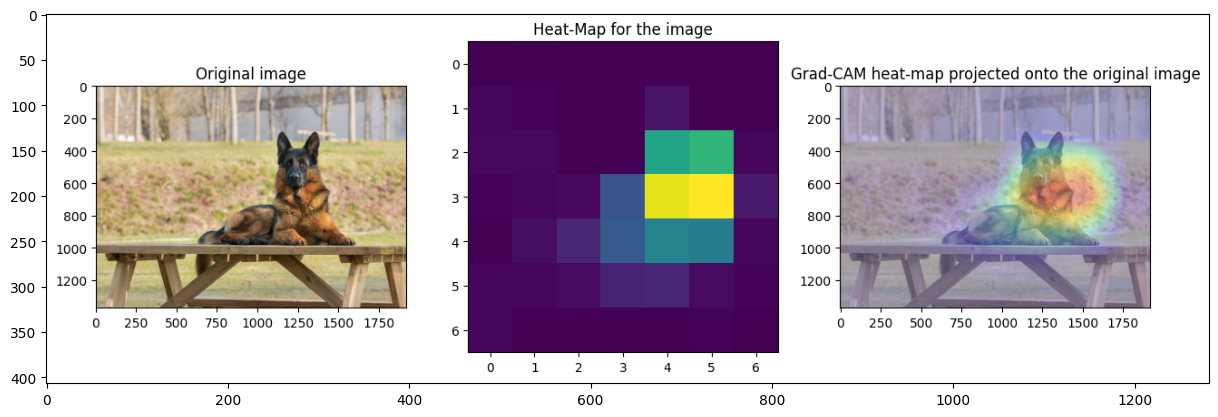

In [12]:
# read and visualize the image

def read_img(path_to_img):
    img = cv.imread(path_to_img) # Insert the path to image.
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img
    
path_to_img = 'gradcam_images/dog.png'
img = read_img(path_to_img)
plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.show()

### To explain GRADCAM for images in imagenet dataset

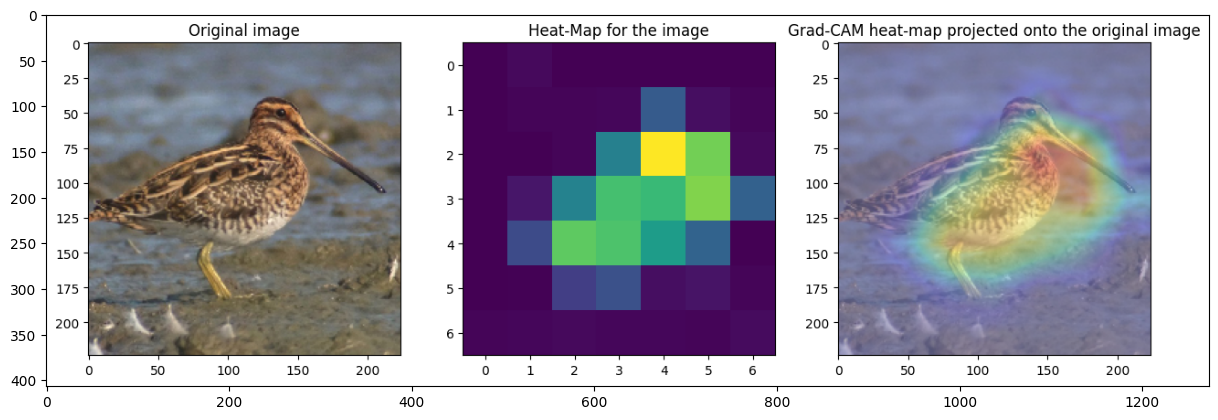

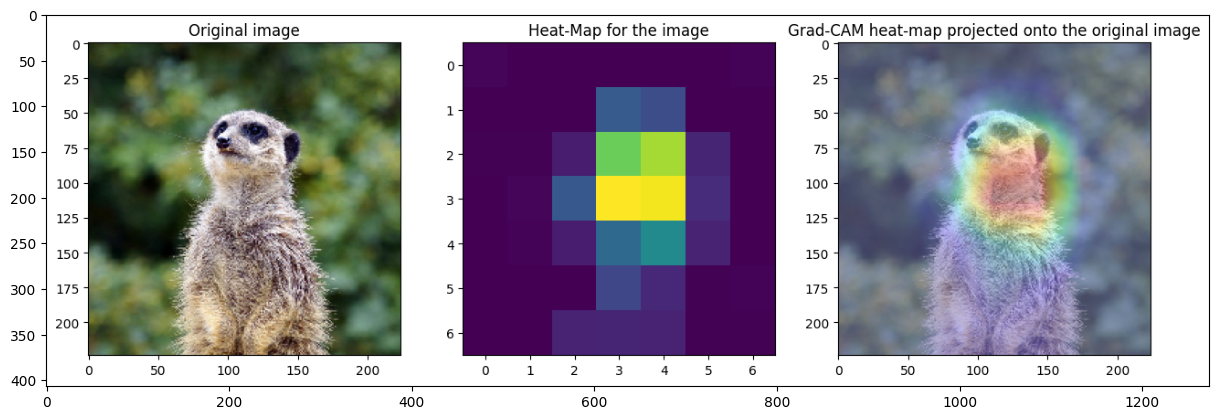

In [17]:
# read and visualize the image
path_to_img1 = 'gradcam_images/dowitcher.png'
img1 = read_img(path_to_img1)

path_to_img2 = 'gradcam_images/mongoose.png'
img2 = read_img(path_to_img2)

plt.figure(figsize=(15, 15))
plt.imshow(img1)
plt.show()

plt.figure(figsize=(15, 15))
plt.imshow(img2)
plt.show()

## SHAP for image classification

### How does SHAP work?
* SHAP is based on Shapley value, a method to calculate the contributions of each player to the outcome of a game.
* The Shapley value is calculated with all possible combinations of players. Given N players, it has to calculate outcomes for 2^N combinations of players. In the case of machine learning, the “players” are the features (e.g. pixels in an image) and the “outcome of a game” is the model’s prediction. Calculating the contribution of each feature is not feasible for large numbers of N. For example, for images, N is the number of pixels.
* Therefore, SHAP does not attempt to calculate the actual Shapley value. Instead, it uses sampling and approximations to calculate the SHAP value.
* There are multiple explainers from SHAP that can be used to explain which features are important in an image for classification. Some of them are,
    * GradientExplainer
    * PartitionExplainer
    * DeepExplainer
* All of the above uses specific methods to approximate SHAP values for deep learning models.

### To explain shap values for a custom image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


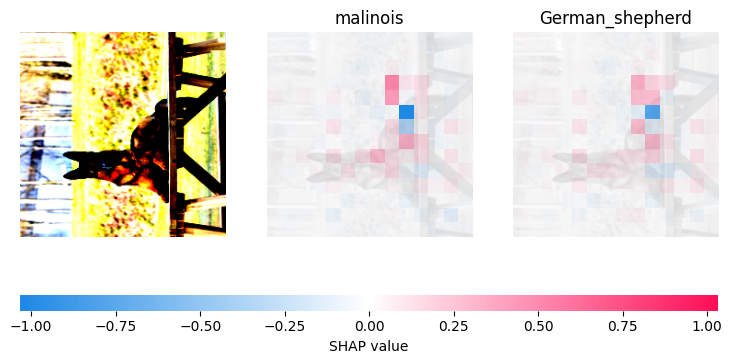

In [14]:
# read and visualize the image
path_to_img = 'images/dog.jpg'
img = read_img(path_to_img)


# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

def normalize(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()

X,y = shap.datasets.imagenet50()
X /= 255

to_explain = transform_img(img)

e = shap.GradientExplainer((model, model.layer4), normalize(X))
shap_values,indexes = e.shap_values(to_explain,ranked_outputs=2, nsamples=200)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

to_plot_explain = transform_img(img,"N")
# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
shap.image_plot(shap_values, to_plot_explain, index_names)

SHAP uses colors to explain attributions:
* Red pixels increase the probability of a class being predicted.
* Blue pixels decrease the probability of a class being predicted.
* The sum of the SHAP values equals the difference between the expected model output (averaged over the background dataset) and the current model output.

### To explain shap values for images in imagenet dataset

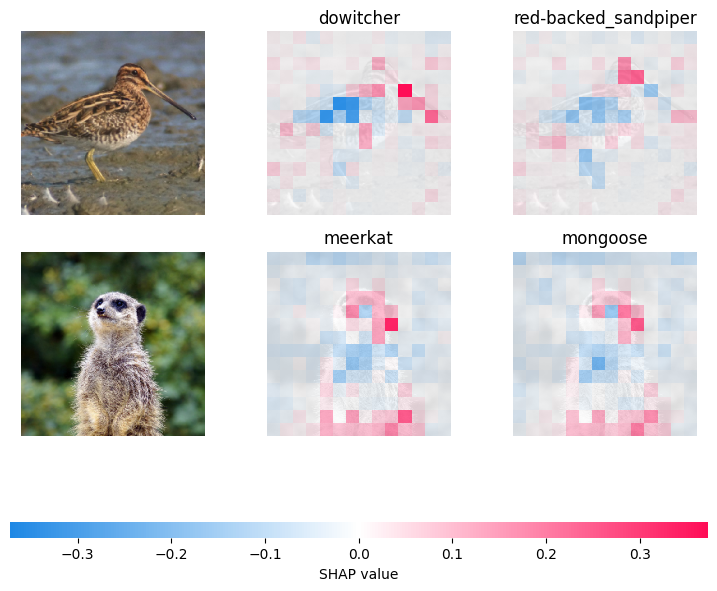

In [15]:
# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

def normalize(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()

X,y = shap.datasets.imagenet50()
X /= 255

to_explain = X[[39,41]]

e = shap.GradientExplainer((model, model.layer4), normalize(X))
shap_values,indexes = e.shap_values(normalize(to_explain),ranked_outputs=2, nsamples=200)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
shap.image_plot(shap_values, to_explain, index_names)

## Gradient-based method vs Occlusion

### Gradient-based,
* Leverages the gradient of the function, so that a mapping of the function value onto the multiple input dimensions is readily obtained [45,50]. 
* The method of integrated gradients [50], in particular, attributes the prediction to input features by integrating the gradient along a path connecting some reference point (e.g. the origin) to the data point. 
* The method requires somewhere between ten and a hundred function evaluations, and satisfies the aforementioned conservation property. 
* The main advantage of gradient-based methods is that, by leveraging the gradient information in addi- tion to the function value, one no longer has to perturb each input feature individually to produce an explanation.

### Occlusion-based, 
* Consists of testing the function to explain against various occlusions of the input features [53,54]. An important method of this family (and which was originally developed in the context of game theory) is the Shapley value [29,43,48]. 
* The Shapley value identifies a unique attribution that satisfies some predefined set of axioms of an explanation, including the conservation property stated above. While the approach has strong theoretical underpinnings, computing the explanation however requires an exponential number of function evaluations (an evaluation for every subset of input features). 
* The main advantage is that the above attribution makes the Shapley value in its basic form intractable for any problem with more than a few input dimensions.

## Pros and Cons of GradCAM

## Pros and Cons of SHAP